In [ ]:
import pickle
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

import time
import datetime

print(datetime.datetime.now())

In [2]:
path_data = '../data/d20220201/'

# INPUTS
fn_finalSave = path_data + 'featuresAndMeta_s20220720.p'
fn_predictionsTraining  = path_data + 'predictionsTraining_binary_s20230504.xlsx'
fn_predictionsValidation = path_data + 'predictionsValidation_binary_s20230508.xlsx'
fn_forLorenz = path_data + 'radipopPredictions_toLorenz.csv'

# OUTPUTS
fn_figure_km = '../figures/f_kapMeier_s20230516.svg'
fn_figure_km_big = '../figures/f_kapMeier_big_s20230516.svg'
fn_f_survivalCurve_HVPG = '../figures/f_survivalCurveHVPG_s20230516.png'
fn_f_survivalCurve_pHVPG = '../figures/f_survivalCurvepHVPG_s20230516.png'
fn_f_survivalCurve_thumb = '../figures/f_survivalCurveThumb_s20230516.svg'

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout']=False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
with open(fn_finalSave, "rb") as input_file:
    dict_data = pickle.load(input_file)

dict_data.keys()

dict_keys(['df_rawFeatures_training', 'df_rawFeatures_validation', 'dict_normalizationFactors', 'df_zscoreFeatures_training', 'df_zscoreFeatures_validation', 'df_metadata', 'umap_raw', 'umap_zscore'])

In [4]:
predictions_train = pd.read_excel(fn_predictionsTraining, index_col=0)
predictions_validations = pd.read_excel(fn_predictionsValidation, index_col=0)
predictions_binary = pd.concat([predictions_train, predictions_validations])
predictions_binary['id'] = predictions_binary.index
predictions_binary['id'] = predictions_binary['id'].apply(lambda x: str(x).zfill(4))
predictions_binary = predictions_binary.set_index('id')

In [ ]:
predictions_binary[500:550]

In [6]:
currMeta = dict_data['df_metadata']
currMeta.isnull().sum()

trainTest               0
age                     0
sex                     0
ct_grp                  0
lre                   120
lre_tf                120
decompBL              120
lrd                   120
lrd_tf                120
survival              120
survival_tf           120
tfs                   120
tfs_tf                120
hvpg_corrected        120
hvpg_grp              120
decompensated_acld    120
hepLrd_time           120
hepLrd_180            120
hepLrd_360            120
cps                   120
cps_grp               120
meld                  120
meld_grp              120
etiology              120
sodium                120
creatinine            120
albumin               120
CRP                   120
INR                   120
bilirubin             120
cntl_grp                0
patientID               0
dtype: int64

In [ ]:
currMeta = currMeta.dropna()

# make variables
temp = pd.get_dummies(currMeta['meld_grp'], prefix='meldgrp')
currMeta = pd.concat([currMeta, temp], axis = 1)
temp = pd.get_dummies(currMeta['cps_grp'], prefix='cpsgrp')
currMeta = pd.concat([currMeta, temp], axis = 1)

currMeta['etio_alcLiverDisease'] = currMeta['etiology'].apply(lambda x: True if x == '1' else False)
currMeta['etio_nonAlcFattyLiver'] = currMeta['etiology'].apply(lambda x: True if x == '2' else False)
currMeta['etio_viral'] = currMeta['etiology'].apply(lambda x: True if x == '3' else False)
currMeta['etio_other'] = currMeta['etiology'].apply(lambda x: True if x == '4' else False)
currMeta['etio_unknown'] = currMeta['etiology'].apply(lambda x: True if x == '5' else False)

# create composite endpoint: lre OR lrd
currMeta['lre_or_lrd_tf'] = (~currMeta['decompBL'].astype(bool)) | (currMeta['lrd_tf']) # what celine thinks is correct
# #currMeta['lre_or_lrd_tf'] = (currMeta['decompBL'].astype(bool)) | (currMeta['lrd_tf'])
currMeta['lre_or_lrd'] = currMeta[['lre','lrd']].min(axis=1)

# add radipop predictions
currMeta = currMeta.merge(predictions_binary[['pred_bin']], how='inner', left_index=True, right_index=True)

currMeta

In [8]:
currMeta[['lre', 'lre_or_lrd']]

,lre,lre_or_lrd
0001,27.383300,27.383300
0002,12.590401,12.590401
0004,27.251808,27.251808
0005,15.384615,15.384615
0006,22.846811,22.846811
...,...,...
0509,54.996713,54.996713
0510,63.773833,63.773833
0511,22.320842,22.320842
0512,18.869165,18.869165


In [9]:
np.where((currMeta['lre'] != currMeta['lre_or_lrd']))
np.where((currMeta['lre'] > currMeta['lrd']))

(array([ 29, 182]),)

In [ ]:
toLorenz = currMeta[['hvpg_corrected','pred_bin']]
toLorenz.to_csv(fn_forLorenz)

toLorenz

In [ ]:
toLorenz.iloc[[116,128,141]]

In [12]:
timetuples = [('survival', 'survival_tf'), 
              ('lrd', 'lrd_tf'),
              ('tfs', 'tfs_tf'),
              ('lre', 'decompBL')]

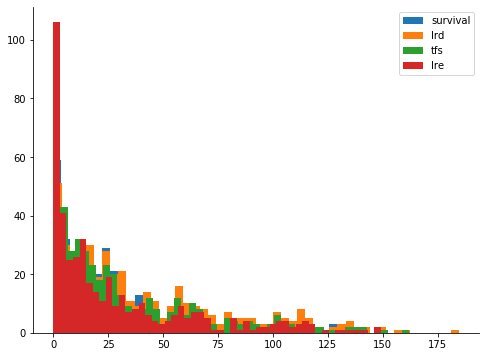

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
for eaTuple in timetuples:
    time = currMeta[eaTuple[0]]
    plt.hist(time, bins = 50, label=eaTuple[0])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['survival', 'lrd', 'tfs', 'lre'])

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


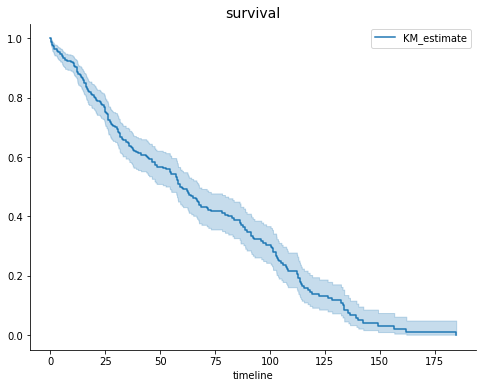

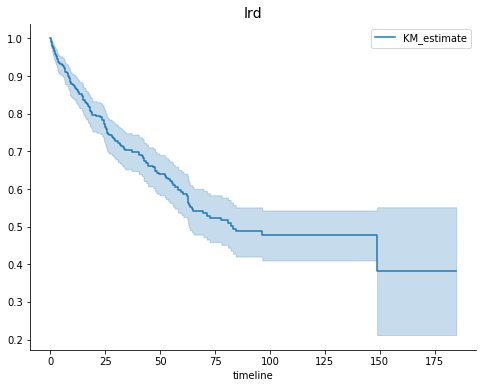

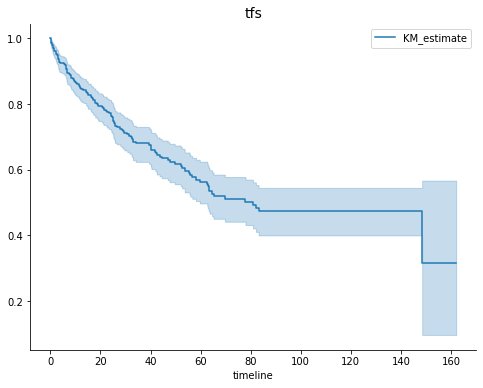

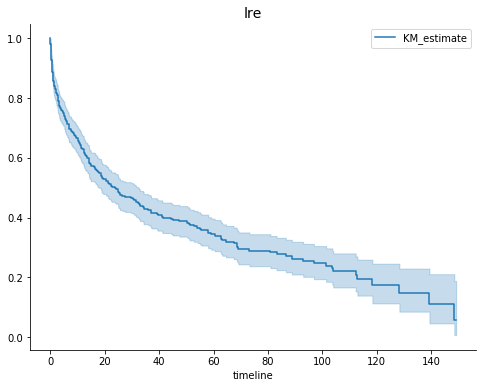

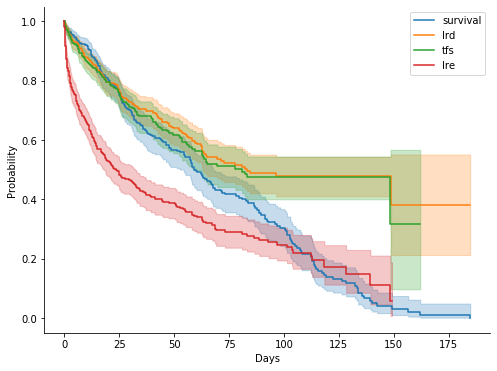

In [14]:
for eaTuple in timetuples:
    time = currMeta[eaTuple[0]]
    status = currMeta[eaTuple[1]]
    kmf = KaplanMeierFitter()
    kmf.fit(durations = time, event_observed = status)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    kmf.plot_survival_function()
    plt.title(eaTuple[0])

fig, ax = plt.subplots(figsize=(8, 6))
for eaTuple in timetuples:
    time = currMeta[eaTuple[0]]
    status = currMeta[eaTuple[1]]
    kmf = KaplanMeierFitter()
    kmf.fit(durations = time, event_observed = status)
    kmf.plot_survival_function()
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['survival', 'lrd', 'tfs', 'lre'])
plt.xlabel('Days')
plt.ylabel('Probability')
plt.savefig(fn_figure_km_big)

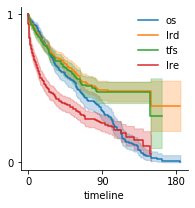

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))
for eaTuple in timetuples:
    time = currMeta[eaTuple[0]]
    status = currMeta[eaTuple[1]]
    kmf = KaplanMeierFitter()
    kmf.fit(durations = time, event_observed = status)
    kmf.plot_survival_function()

plt.yticks([0, 1])
plt.xticks([0, 90, 180])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['os', 'lrd', 'tfs', 'lre'], frameon=False)

plt.savefig(fn_figure_km)

In [16]:
currMeta.columns

Index(['trainTest', 'age', 'sex', 'ct_grp', 'lre', 'lre_tf', 'decompBL', 'lrd',
       'lrd_tf', 'survival', 'survival_tf', 'tfs', 'tfs_tf', 'hvpg_corrected',
       'hvpg_grp', 'decompensated_acld', 'hepLrd_time', 'hepLrd_180',
       'hepLrd_360', 'cps', 'cps_grp', 'meld', 'meld_grp', 'etiology',
       'sodium', 'creatinine', 'albumin', 'CRP', 'INR', 'bilirubin',
       'cntl_grp', 'patientID', 'meldgrp_0', 'meldgrp_1', 'meldgrp_2',
       'cpsgrp_1', 'cpsgrp_2', 'cpsgrp_3', 'etio_alcLiverDisease',
       'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other', 'etio_unknown',
       'lre_or_lrd_tf', 'lre_or_lrd', 'pred_bin'],
      dtype='object')

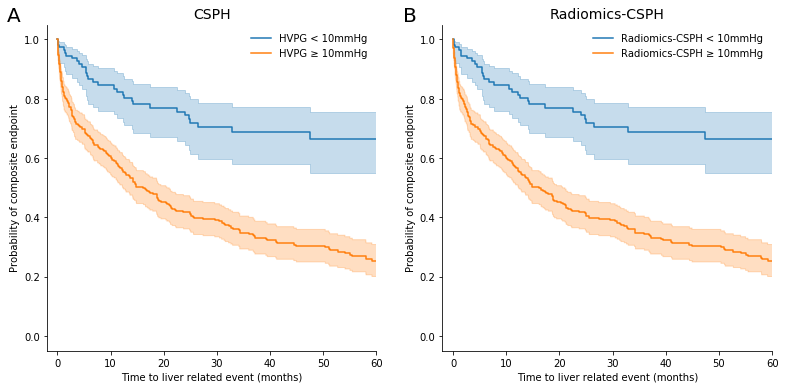

In [17]:
# 'survival', 'survival_tf'
grp_lowHVPG = currMeta[currMeta['hvpg_corrected']<10]
grp_highHVPG = currMeta[currMeta['hvpg_corrected']>=10]

fig, ax = plt.subplots(1,2, figsize=(13, 6))

plt.axes(ax[0])

time = grp_lowHVPG['lre']
status = grp_lowHVPG['decompBL']
kmf = KaplanMeierFitter()
kmf.fit(durations = time, event_observed = status)
kmf.plot_survival_function()

time = grp_highHVPG['lre']
status = grp_highHVPG['decompBL']
kmf = KaplanMeierFitter()
kmf.fit(durations = time, event_observed = status)
kmf.plot_survival_function()

plt.ylabel('Probability of composite endpoint')
plt.xlabel('Time to liver related event (months)')
plt.legend(handles, ['HVPG < 10mmHg', 'HVPG ≥ 10mmHg'], frameon=False)
plt.title('CSPH')
plt.xlim(-2, 60)
plt.text(-0.12, 1.01, 'A', fontsize = 20, transform=ax[0].transAxes)


# 'survival', 'survival_tf'
grp_lowPredHVPG = currMeta[currMeta['pred_bin']==0]
grp_highPredHVPG = currMeta[currMeta['pred_bin']==1]

plt.axes(ax[1])

time = grp_lowHVPG['lre']
status = grp_lowHVPG['decompBL']
kmf = KaplanMeierFitter()
kmf.fit(durations = time, event_observed = status)
kmf.plot_survival_function()

time = grp_highHVPG['lre']
status = grp_highHVPG['decompBL']
kmf = KaplanMeierFitter()
kmf.fit(durations = time, event_observed = status)
kmf.plot_survival_function()

plt.ylabel('Probability of composite endpoint')
plt.xlabel('Time to liver related event (months)')
plt.legend(handles, ['Radiomics-CSPH < 10mmHg', 'Radiomics-CSPH ≥ 10mmHg'], frameon=False)
plt.title('Radiomics-CSPH')
plt.xlim(-2, 60)
plt.text(-0.12, 1.01, 'B', fontsize = 20, transform=ax[1].transAxes)

plt.savefig(fn_f_survivalCurve_HVPG)

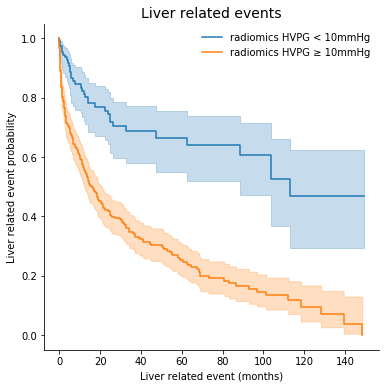

In [18]:
# 'survival', 'survival_tf'
grp_lowPredHVPG = currMeta[currMeta['pred_bin']==0]
grp_highPredHVPG = currMeta[currMeta['pred_bin']==1]

fig, ax = plt.subplots(figsize=(6, 6))

time = grp_lowHVPG['lre']
status = grp_lowHVPG['decompBL']
kmf = KaplanMeierFitter()
kmf.fit(durations = time, event_observed = status)
kmf.plot_survival_function()

time = grp_highHVPG['lre']
status = grp_highHVPG['decompBL']
kmf = KaplanMeierFitter()
kmf.fit(durations = time, event_observed = status)
kmf.plot_survival_function()

plt.ylabel('Liver related event probability')
plt.xlabel('Liver related event (months)')
ax.legend(handles, ['radiomics HVPG < 10mmHg', 'radiomics HVPG ≥ 10mmHg'], frameon=False)
plt.title('Liver related events')

plt.savefig(fn_f_survivalCurve_pHVPG)

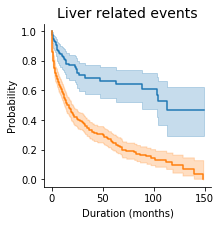

In [19]:
## THUMBNAIL for graphical abstract

fig, ax = plt.subplots(figsize=(3, 3))

time = grp_lowHVPG['lre']
status = grp_lowHVPG['decompBL']
kmf = KaplanMeierFitter()
kmf.fit(durations = time, event_observed = status)
kmf.plot_survival_function()

time = grp_highHVPG['lre']
status = grp_highHVPG['decompBL']
kmf = KaplanMeierFitter()
kmf.fit(durations = time, event_observed = status)
kmf.plot_survival_function()

plt.ylabel('Probability')
plt.xlabel('Duration (months)')
ax.get_legend().remove()
plt.title('Liver related events')

plt.savefig(fn_f_survivalCurve_thumb)

In [20]:
cov_sets = {#'cps': ['age', 'sex',
#                     'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                     'cps_grp',
#                     'sodium', 'creatinine'],
#             'meld': ['age', 'sex',
#                      'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                      'meld',
#                      'albumin'],
            'radipop': ['age', 'sex',
                        'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
                        'sodium', 'creatinine', 'CRP', 'bilirubin', 'albumin', 'INR', 
                        'pred_bin'],
            'radipop+cps': ['age', 'sex',
                            'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
                            'cps_grp',
                            'sodium', 'creatinine',
                            'pred_bin'],
            'radipop+meld': ['age', 'sex',
                             'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
                             'meld',
                             'albumin',
                             'pred_bin'],            
#             'radipop_3g': ['age', 'sex',
#                         'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                         'sodium', 'creatinine', 'CRP', 'bilirubin', 'albumin', 'INR', 
#                         'pred_3g'],
#             'radipop_3g+cps': ['age', 'sex',
#                             'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                             'cps_grp',
#                             'sodium', 'creatinine',
#                             'pred_3g'],
#             'radipop_3g+meld': ['age', 'sex',
#                              'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                              'meld',
#                              'albumin',
#                              'pred_3g'],               
            'measured': ['age', 'sex',
                         'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
                         'sodium', 'creatinine', 'CRP', 'bilirubin', 'albumin', 'INR', 
                         'hvpg_corrected'], 
            'measured+cps': ['age', 'sex',
                            'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
                            'cps_grp',
                            'sodium', 'creatinine',
                            'hvpg_corrected'],
            'measured+meld': ['age', 'sex',
                             'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
                             'meld',
                             'albumin',
                             'hvpg_corrected'],
            'meas_grp': ['age', 'sex',
                         'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
                         'sodium', 'creatinine', 'CRP', 'bilirubin', 'albumin', 'INR', 
                         'hvpg_grp'], 
            'meas_grp+cps': ['age', 'sex',
                            'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
                            'cps_grp',
                            'sodium', 'creatinine',
                            'hvpg_grp'],
            'meas_grp+meld': ['age', 'sex',
                             'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
                             'meld',
                             'albumin',
                             'hvpg_grp']
           }

In [21]:
allModels={}
results = pd.DataFrame()

for eaTuple in timetuples:
    for eaCovset in cov_sets:
        curr_cov = copy.deepcopy(cov_sets[eaCovset])
        curr_cov.extend([eaTuple[0], eaTuple[1]])
        temp = currMeta[curr_cov]
        cph = CoxPHFitter()
        cph.fit(temp, duration_col = eaTuple[0], event_col = eaTuple[1])
        cph.print_summary()
        modelname = eaTuple[0] + '_' + eaCovset
        allModels[modelname] = cph
        
        currResults = dict(cph.hazard_ratios_)
        currResults['AIC'] = cph.AIC_partial_
        currResults['Concordance'] = cph.concordance_index_
        curr_df = pd.DataFrame.from_dict(currResults, 
                                         orient='index',
                                         columns=[modelname])
        results = pd.merge(results, curr_df, how='outer', left_index=True, right_index=True)

<lifelines.CoxPHFitter: fitted with 442 total observations, 209 right-censored observations>
             duration col = 'survival'
                event col = 'survival_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 233
   partial log-likelihood = -1117.44
         time fit was run = 2023-08-08 13:02:54 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
sex                    -0.23       0.79       0.15            -0.53             0.06                 0.59                 1.06
etio_alcLiverDisease   -0.21       0.81       0.40            -1.00             0.58                 0.37                 1.78
etio_nonAlcFattyLiver   0.10       1.11       0.43            -0.73             0.94                 0.48                 2.55
etio_viral             -0.11       0.89       0.41            -0.91             0.69                 0.40                 1.98
etio_other              0.19       1.21       0.42            -0.63             1.00                 0.53                 2.73
sodium                  0.03       1.03       0.02            -0.01             0.06                 0.99                 1.07
creatinine              0.04       1.04       0.13            -0.23             0.30                 0.80                 1.35
CRP                     0.01       1.01       0.04            -0.07             0.08                 0.94                 1.08
bilirubin               0.01       1.01       0.03            -0.04             0.06                 0.96                 1.07
albumin                 0.02       1.02       0.01            -0.00             0.05                 1.00                 1.05
INR                     0.44       1.55       0.16             0.12             0.75                 1.12                 2.12
pred_bin                0.24       1.27       0.19            -0.12             0.60                 0.89                 1.83

                        cmp to     z    p   -log2(p)
covariate                                           
age                       0.00  2.13 0.03       4.90
sex                       0.00 -1.55 0.12       3.05
etio_alcLiverDisease      0.00 -0.53 0.60       0.74
etio_nonAlcFattyLiver     0.00  0.24 0.81       0.30
etio_viral                0.00 -0.28 0.78       0.36
etio_other                0.00  0.45 0.65       0.62
sodium                    0.00  1.47 0.14       2.82
creatinine                0.00  0.28 0.78       0.36
CRP                       0.00  0.15 0.88       0.18
bilirubin                 0.00  0.43 0.66       0.59
albumin                   0.00  1.70 0.09       3.49
INR                       0.00  2.68 0.01       7.08
pred_bin                  0.00  1.30 0.19       2.37
---
Concordance = 0.60
Partial AIC = 2260.88
log-likelihood ratio test = 26.34 on 13 df
-log2(p) of ll-ratio test = 6.03

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 209 right-censored observations>
             duration col = 'survival'
                event col = 'survival_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 233
   partial log-likelihood = -1122.55
         time fit was run = 2023-08-08 13:02:54 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
sex                    -0.19       0.83       0.15            -0.48             0.10                 0.62                 1.11
etio_alcLiverDisease   -0.17       0.85       0.40            -0.96             0.63                 0.38                 1.87
etio_nonAlcFattyLiver   0.07       1.07       0.43            -0.78             0.92                 0.46                 2.50
etio_viral             -0.11       0.90       0.41            -0.91             0.69                 0.40                 2.00
etio_other              0.18       1.20       0.42            -0.63             1.00                 0.53                 2.72
cps_grp                 0.09       1.09       0.11            -0.13             0.30                 0.88                 1.35
sodium                  0.04       1.04       0.02            -0.00             0.07                 1.00                 1.07
creatinine             -0.00       1.00       0.13            -0.27             0.26                 0.77                 1.30
pred_bin                0.15       1.16       0.18            -0.21             0.50                 0.81                 1.64

                        cmp to     z    p   -log2(p)
covariate                                           
age                       0.00  2.18 0.03       5.10
sex                       0.00 -1.25 0.21       2.25
etio_alcLiverDisease      0.00 -0.42 0.68       0.56
etio_nonAlcFattyLiver     0.00  0.16 0.88       0.19
etio_viral                0.00 -0.26 0.79       0.33
etio_other                0.00  0.44 0.66       0.60
cps_grp                   0.00  0.81 0.42       1.26
sodium                    0.00  1.95 0.05       4.27
creatinine                0.00 -0.02 0.98       0.03
pred_bin                  0.00  0.81 0.42       1.26
---
Concordance = 0.56
Partial AIC = 2265.09
log-likelihood ratio test = 16.13 on 10 df
-log2(p) of ll-ratio test = 3.38

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 209 right-censored observations>
             duration col = 'survival'
                event col = 'survival_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 233
   partial log-likelihood = -1120.73
         time fit was run = 2023-08-08 13:02:55 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
sex                    -0.26       0.77       0.15            -0.55             0.03                 0.58                 1.03
etio_alcLiverDisease   -0.23       0.80       0.40            -1.02             0.56                 0.36                 1.75
etio_nonAlcFattyLiver   0.11       1.12       0.43            -0.73             0.95                 0.48                 2.57
etio_viral             -0.13       0.88       0.41            -0.93             0.66                 0.39                 1.94
etio_other              0.16       1.17       0.42            -0.66             0.97                 0.52                 2.65
meld                    0.03       1.03       0.01             0.01             0.06                 1.01                 1.06
albumin                 0.03       1.03       0.01             0.00             0.05                 1.00                 1.06
pred_bin                0.17       1.19       0.18            -0.19             0.53                 0.83                 1.70

                        cmp to     z    p   -log2(p)
covariate                                           
age                       0.00  2.17 0.03       5.04
sex                       0.00 -1.77 0.08       3.72
etio_alcLiverDisease      0.00 -0.56 0.57       0.80
etio_nonAlcFattyLiver     0.00  0.26 0.80       0.33
etio_viral                0.00 -0.33 0.74       0.43
etio_other                0.00  0.38 0.70       0.51
meld                      0.00  2.56 0.01       6.58
albumin                   0.00  2.15 0.03       4.99
pred_bin                  0.00  0.94 0.35       1.53
---
Concordance = 0.58
Partial AIC = 2259.45
log-likelihood ratio test = 19.77 on 9 df
-log2(p) of ll-ratio test = 5.69

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 209 right-censored observations>
             duration col = 'survival'
                event col = 'survival_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 233
   partial log-likelihood = -1118.05
         time fit was run = 2023-08-08 13:02:55 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
sex                    -0.23       0.80       0.15            -0.52             0.07                 0.59                 1.07
etio_alcLiverDisease   -0.27       0.76       0.41            -1.07             0.53                 0.34                 1.70
etio_nonAlcFattyLiver   0.06       1.06       0.43            -0.78             0.90                 0.46                 2.45
etio_viral             -0.18       0.83       0.41            -0.98             0.61                 0.38                 1.84
etio_other              0.12       1.13       0.41            -0.69             0.93                 0.50                 2.53
sodium                  0.03       1.03       0.02            -0.01             0.06                 0.99                 1.07
creatinine              0.02       1.02       0.13            -0.24             0.29                 0.79                 1.33
CRP                     0.01       1.01       0.04            -0.06             0.08                 0.94                 1.08
bilirubin               0.01       1.01       0.03            -0.04             0.06                 0.96                 1.07
albumin                 0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05
INR                     0.41       1.51       0.16             0.10             0.73                 1.10                 2.07
hvpg_corrected          0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03

                        cmp to     z    p   -log2(p)
covariate                                           
age                       0.00  1.87 0.06       4.03
sex                       0.00 -1.52 0.13       2.95
etio_alcLiverDisease      0.00 -0.66 0.51       0.97
etio_nonAlcFattyLiver     0.00  0.13 0.90       0.16
etio_viral                0.00 -0.46 0.65       0.62
etio_other                0.00  0.29 0.77       0.38
sodium                    0.00  1.48 0.14       2.84
creatinine                0.00  0.18 0.86       0.22
CRP                       0.00  0.19 0.85       0.24
bilirubin                 0.00  0.44 0.66       0.60
albumin                   0.00  1.53 0.13       3.00
INR                       0.00  2.58 0.01       6.66
hvpg_corrected            0.00  0.72 0.47       1.09
---
Concordance = 0.59
Partial AIC = 2262.09
log-likelihood ratio test = 25.13 on 13 df
-log2(p) of ll-ratio test = 5.49

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 209 right-censored observations>
             duration col = 'survival'
                event col = 'survival_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 233
   partial log-likelihood = -1122.77
         time fit was run = 2023-08-08 13:02:55 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01             0.00             0.02                 1.00                 1.02
sex                    -0.18       0.83       0.15            -0.47             0.11                 0.62                 1.11
etio_alcLiverDisease   -0.21       0.81       0.41            -1.01             0.59                 0.37                 1.81
etio_nonAlcFattyLiver   0.04       1.04       0.43            -0.81             0.89                 0.45                 2.43
etio_viral             -0.15       0.86       0.41            -0.94             0.65                 0.39                 1.91
etio_other              0.15       1.16       0.41            -0.66             0.96                 0.52                 2.60
cps_grp                 0.09       1.09       0.11            -0.13             0.31                 0.88                 1.37
sodium                  0.04       1.04       0.02            -0.00             0.07                 1.00                 1.07
creatinine             -0.01       0.99       0.13            -0.27             0.25                 0.76                 1.28
hvpg_corrected          0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03

                        cmp to     z    p   -log2(p)
covariate                                           
age                       0.00  2.02 0.04       4.52
sex                       0.00 -1.24 0.21       2.23
etio_alcLiverDisease      0.00 -0.50 0.61       0.70
etio_nonAlcFattyLiver     0.00  0.09 0.93       0.11
etio_viral                0.00 -0.37 0.71       0.49
etio_other                0.00  0.36 0.72       0.47
cps_grp                   0.00  0.79 0.43       1.22
sodium                    0.00  1.93 0.05       4.21
creatinine                0.00 -0.08 0.94       0.09
hvpg_corrected            0.00  0.47 0.64       0.65
---
Concordance = 0.56
Partial AIC = 2265.54
log-likelihood ratio test = 15.69 on 10 df
-log2(p) of ll-ratio test = 3.20

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 209 right-censored observations>
             duration col = 'survival'
                event col = 'survival_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 233
   partial log-likelihood = -1121.17
         time fit was run = 2023-08-08 13:02:55 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01             0.00             0.02                 1.00                 1.03
sex                    -0.26       0.77       0.15            -0.55             0.02                 0.57                 1.03
etio_alcLiverDisease   -0.24       0.79       0.41            -1.04             0.56                 0.35                 1.75
etio_nonAlcFattyLiver   0.09       1.10       0.43            -0.74             0.93                 0.48                 2.54
etio_viral             -0.17       0.84       0.40            -0.97             0.62                 0.38                 1.86
etio_other              0.10       1.11       0.41            -0.71             0.91                 0.49                 2.48
meld                    0.03       1.04       0.01             0.01             0.06                 1.01                 1.06
albumin                 0.03       1.03       0.01            -0.00             0.05                 1.00                 1.05
hvpg_corrected          0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02

                        cmp to     z    p   -log2(p)
covariate                                           
age                       0.00  2.02 0.04       4.53
sex                       0.00 -1.79 0.07       3.77
etio_alcLiverDisease      0.00 -0.58 0.56       0.83
etio_nonAlcFattyLiver     0.00  0.22 0.83       0.27
etio_viral                0.00 -0.43 0.67       0.58
etio_other                0.00  0.25 0.81       0.31
meld                      0.00  2.51 0.01       6.39
albumin                   0.00  1.94 0.05       4.25
hvpg_corrected            0.00  0.13 0.90       0.15
---
Concordance = 0.58
Partial AIC = 2260.33
log-likelihood ratio test = 18.89 on 9 df
-log2(p) of ll-ratio test = 5.26

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 209 right-censored observations>
             duration col = 'survival'
                event col = 'survival_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 233
   partial log-likelihood = -1116.76
         time fit was run = 2023-08-08 13:02:55 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01            -0.00             0.02                 1.00                 1.03
sex                    -0.21       0.81       0.15            -0.51             0.08                 0.60                 1.09
etio_alcLiverDisease   -0.31       0.73       0.41            -1.11             0.49                 0.33                 1.63
etio_nonAlcFattyLiver   0.04       1.04       0.43            -0.80             0.87                 0.45                 2.40
etio_viral             -0.18       0.84       0.41            -0.97             0.62                 0.38                 1.86
etio_other              0.18       1.20       0.41            -0.63             0.99                 0.53                 2.69
sodium                  0.03       1.03       0.02            -0.01             0.07                 0.99                 1.07
creatinine              0.04       1.04       0.13            -0.23             0.30                 0.80                 1.35
CRP                     0.01       1.01       0.04            -0.06             0.08                 0.94                 1.09
bilirubin               0.01       1.01       0.03            -0.04             0.06                 0.96                 1.07
albumin                 0.02       1.03       0.01            -0.00             0.05                 1.00                 1.05
INR                     0.41       1.50       0.16             0.09             0.73                 1.09                 2.07
hvpg_grp                0.13       1.13       0.07            -0.02             0.27                 0.98                 1.31

                        cmp to     z    p   -log2(p)
covariate                                           
age                       0.00  1.95 0.05       4.30
sex                       0.00 -1.41 0.16       2.66
etio_alcLiverDisease      0.00 -0.76 0.45       1.16
etio_nonAlcFattyLiver     0.00  0.09 0.93       0.10
etio_viral                0.00 -0.43 0.66       0.59
etio_other                0.00  0.43 0.66       0.59
sodium                    0.00  1.57 0.12       3.10
creatinine                0.00  0.27 0.79       0.34
CRP                       0.00  0.38 0.70       0.51
bilirubin                 0.00  0.40 0.69       0.54
albumin                   0.00  1.86 0.06       3.99
INR                       0.00  2.50 0.01       6.32
hvpg_grp                  0.00  1.75 0.08       3.64
---
Concordance = 0.60
Partial AIC = 2259.52
log-likelihood ratio test = 27.70 on 13 df
-log2(p) of ll-ratio test = 6.65

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 209 right-censored observations>
             duration col = 'survival'
                event col = 'survival_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 233
   partial log-likelihood = -1121.65
         time fit was run = 2023-08-08 13:02:55 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01             0.00             0.02                 1.00                 1.03
sex                    -0.16       0.85       0.15            -0.45             0.13                 0.64                 1.14
etio_alcLiverDisease   -0.24       0.78       0.41            -1.04             0.55                 0.35                 1.74
etio_nonAlcFattyLiver   0.04       1.04       0.43            -0.81             0.88                 0.45                 2.42
etio_viral             -0.14       0.87       0.41            -0.93             0.66                 0.39                 1.93
etio_other              0.21       1.24       0.41            -0.60             1.03                 0.55                 2.79
cps_grp                 0.06       1.07       0.11            -0.15             0.28                 0.86                 1.32
sodium                  0.04       1.04       0.02             0.00             0.07                 1.00                 1.08
creatinine              0.00       1.00       0.13            -0.26             0.26                 0.77                 1.30
hvpg_grp                0.11       1.11       0.07            -0.03             0.24                 0.97                 1.27

                        cmp to     z    p   -log2(p)
covariate                                           
age                       0.00  2.08 0.04       4.73
sex                       0.00 -1.09 0.28       1.86
etio_alcLiverDisease      0.00 -0.60 0.55       0.86
etio_nonAlcFattyLiver     0.00  0.09 0.93       0.10
etio_viral                0.00 -0.34 0.74       0.44
etio_other                0.00  0.51 0.61       0.72
cps_grp                   0.00  0.58 0.56       0.82
sodium                    0.00  2.03 0.04       4.57
creatinine                0.00  0.00 1.00       0.00
hvpg_grp                  0.00  1.56 0.12       3.06
---
Concordance = 0.57
Partial AIC = 2263.31
log-likelihood ratio test = 17.92 on 10 df
-log2(p) of ll-ratio test = 4.15

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 209 right-censored observations>
             duration col = 'survival'
                event col = 'survival_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 233
   partial log-likelihood = -1120.30
         time fit was run = 2023-08-08 13:02:56 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01             0.00             0.02                 1.00                 1.03
sex                    -0.24       0.79       0.15            -0.53             0.05                 0.59                 1.05
etio_alcLiverDisease   -0.30       0.74       0.41            -1.09             0.50                 0.34                 1.65
etio_nonAlcFattyLiver   0.07       1.07       0.43            -0.77             0.90                 0.46                 2.47
etio_viral             -0.18       0.84       0.40            -0.97             0.62                 0.38                 1.85
etio_other              0.16       1.17       0.41            -0.65             0.97                 0.52                 2.64
meld                    0.03       1.03       0.01             0.00             0.06                 1.00                 1.06
albumin                 0.03       1.03       0.01             0.00             0.05                 1.00                 1.06
hvpg_grp                0.09       1.10       0.07            -0.05             0.23                 0.95                 1.26

                        cmp to     z    p   -log2(p)
covariate                                           
age                       0.00  2.03 0.04       4.57
sex                       0.00 -1.62 0.10       3.25
etio_alcLiverDisease      0.00 -0.73 0.47       1.10
etio_nonAlcFattyLiver     0.00  0.16 0.87       0.20
etio_viral                0.00 -0.44 0.66       0.60
etio_other                0.00  0.39 0.70       0.52
meld                      0.00  2.26 0.02       5.39
albumin                   0.00  2.21 0.03       5.19
hvpg_grp                  0.00  1.31 0.19       2.40
---
Concordance = 0.58
Partial AIC = 2258.61
log-likelihood ratio test = 20.61 on 9 df
-log2(p) of ll-ratio test = 6.11

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 290 right-censored observations>
             duration col = 'lrd'
                event col = 'lrd_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 152
   partial log-likelihood = -804.09
         time fit was run = 2023-08-08 13:02:56 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
sex                    -0.05       0.95       0.19            -0.42             0.32                 0.66                 1.38
etio_alcLiverDisease    0.17       1.18       0.48            -0.76             1.10                 0.47                 3.01
etio_nonAlcFattyLiver  -0.00       1.00       0.52            -1.03             1.02                 0.36                 2.78
etio_viral              0.12       1.12       0.49            -0.85             1.08                 0.43                 2.95
etio_other              0.36       1.44       0.50            -0.62             1.34                 0.54                 3.83
sodium                 -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
creatinine             -0.01       0.99       0.17            -0.34             0.32                 0.71                 1.38
CRP                     0.06       1.07       0.03             0.00             0.13                 1.00                 1.14
bilirubin               0.03       1.03       0.03            -0.03             0.08                 0.97                 1.09
albumin                -0.03       0.97       0.02            -0.06            -0.00                 0.94                 1.00
INR                     0.10       1.11       0.24            -0.37             0.57                 0.69                 1.78
pred_bin                0.56       1.75       0.27             0.04             1.08                 1.04                 2.95

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.90 <0.005      19.97
sex                       0.00 -0.25   0.80       0.32
etio_alcLiverDisease      0.00  0.36   0.72       0.47
etio_nonAlcFattyLiver     0.00 -0.01   0.99       0.01
etio_viral                0.00  0.23   0.81       0.30
etio_other                0.00  0.73   0.47       1.10
sodium                    0.00 -0.81   0.42       1.26
creatinine                0.00 -0.04   0.97       0.05
CRP                       0.00  2.02   0.04       4.53
bilirubin                 0.00  0.90   0.37       1.45
albumin                   0.00 -2.03   0.04       4.55
INR                       0.00  0.43   0.67       0.58
pred_bin                  0.00  2.11   0.04       4.83
---
Concordance = 0.65
Partial AIC = 1634.18
log-likelihood ratio test = 48.51 on 13 df
-log2(p) of ll-ratio test = 17.51

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 290 right-censored observations>
             duration col = 'lrd'
                event col = 'lrd_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 152
   partial log-likelihood = -806.90
         time fit was run = 2023-08-08 13:02:56 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
sex                     0.00       1.00       0.19            -0.37             0.37                 0.69                 1.45
etio_alcLiverDisease    0.05       1.05       0.48            -0.89             0.98                 0.41                 2.67
etio_nonAlcFattyLiver  -0.16       0.85       0.53            -1.20             0.87                 0.30                 2.40
etio_viral              0.03       1.03       0.49            -0.94             1.00                 0.39                 2.71
etio_other              0.32       1.37       0.50            -0.66             1.29                 0.52                 3.65
cps_grp                 0.42       1.52       0.13             0.16             0.67                 1.18                 1.96
sodium                 -0.02       0.98       0.02            -0.05             0.02                 0.95                 1.02
creatinine             -0.01       0.99       0.17            -0.34             0.33                 0.71                 1.39
pred_bin                0.59       1.80       0.26             0.07             1.10                 1.08                 3.02

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.67 <0.005      18.34
sex                       0.00  0.02   0.98       0.03
etio_alcLiverDisease      0.00  0.10   0.92       0.12
etio_nonAlcFattyLiver     0.00 -0.30   0.76       0.40
etio_viral                0.00  0.06   0.95       0.07
etio_other                0.00  0.64   0.53       0.93
cps_grp                   0.00  3.22 <0.005       9.60
sodium                    0.00 -0.86   0.39       1.36
creatinine                0.00 -0.04   0.97       0.04
pred_bin                  0.00  2.24   0.03       5.32
---
Concordance = 0.64
Partial AIC = 1633.81
log-likelihood ratio test = 42.88 on 10 df
-log2(p) of ll-ratio test = 17.55

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 290 right-censored observations>
             duration col = 'lrd'
                event col = 'lrd_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 152
   partial log-likelihood = -806.27
         time fit was run = 2023-08-08 13:02:56 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.06
sex                    -0.02       0.98       0.18            -0.38             0.34                 0.68                 1.41
etio_alcLiverDisease    0.16       1.17       0.47            -0.77             1.09                 0.46                 2.97
etio_nonAlcFattyLiver   0.01       1.01       0.52            -1.02             1.03                 0.36                 2.80
etio_viral              0.07       1.07       0.49            -0.89             1.03                 0.41                 2.81
etio_other              0.39       1.48       0.50            -0.59             1.37                 0.56                 3.93
meld                    0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
albumin                -0.04       0.96       0.02            -0.07            -0.01                 0.93                 0.99
pred_bin                0.54       1.72       0.26             0.02             1.06                 1.02                 2.89

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.72 <0.005      18.66
sex                       0.00 -0.10   0.92       0.12
etio_alcLiverDisease      0.00  0.34   0.73       0.44
etio_nonAlcFattyLiver     0.00  0.01   0.99       0.02
etio_viral                0.00  0.14   0.89       0.18
etio_other                0.00  0.78   0.43       1.21
meld                      0.00  1.66   0.10       3.37
albumin                   0.00 -2.59   0.01       6.70
pred_bin                  0.00  2.04   0.04       4.60
---
Concordance = 0.65
Partial AIC = 1630.53
log-likelihood ratio test = 44.16 on 9 df
-log2(p) of ll-ratio test = 19.53

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 290 right-censored observations>
             duration col = 'lrd'
                event col = 'lrd_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 152
   partial log-likelihood = -804.87
         time fit was run = 2023-08-08 13:02:56 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
sex                    -0.05       0.95       0.19            -0.42             0.33                 0.66                 1.39
etio_alcLiverDisease    0.03       1.03       0.48            -0.91             0.97                 0.40                 2.65
etio_nonAlcFattyLiver  -0.11       0.89       0.52            -1.14             0.91                 0.32                 2.49
etio_viral             -0.02       0.98       0.49            -0.98             0.94                 0.38                 2.57
etio_other              0.25       1.28       0.49            -0.72             1.22                 0.49                 3.38
sodium                 -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
creatinine             -0.03       0.97       0.17            -0.35             0.30                 0.70                 1.35
CRP                     0.07       1.08       0.03             0.01             0.14                 1.01                 1.15
bilirubin               0.03       1.03       0.03            -0.03             0.08                 0.97                 1.09
albumin                -0.03       0.97       0.02            -0.06             0.00                 0.94                 1.00
INR                     0.07       1.08       0.24            -0.39             0.54                 0.67                 1.71
hvpg_corrected          0.02       1.02       0.01            -0.00             0.04                 1.00                 1.05

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.55 <0.005      17.49
sex                       0.00 -0.24   0.81       0.31
etio_alcLiverDisease      0.00  0.07   0.95       0.08
etio_nonAlcFattyLiver     0.00 -0.22   0.83       0.27
etio_viral                0.00 -0.04   0.97       0.04
etio_other                0.00  0.51   0.61       0.71
sodium                    0.00 -0.73   0.46       1.11
creatinine                0.00 -0.16   0.87       0.19
CRP                       0.00  2.22   0.03       5.25
bilirubin                 0.00  0.90   0.37       1.44
albumin                   0.00 -1.94   0.05       4.26
INR                       0.00  0.30   0.76       0.39
hvpg_corrected            0.00  1.85   0.06       3.95
---
Concordance = 0.65
Partial AIC = 1635.73
log-likelihood ratio test = 46.96 on 13 df
-log2(p) of ll-ratio test = 16.63

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 290 right-censored observations>
             duration col = 'lrd'
                event col = 'lrd_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 152
   partial log-likelihood = -808.37
         time fit was run = 2023-08-08 13:02:56 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
sex                     0.00       1.00       0.19            -0.37             0.37                 0.69                 1.45
etio_alcLiverDisease   -0.08       0.92       0.48            -1.02             0.86                 0.36                 2.36
etio_nonAlcFattyLiver  -0.25       0.78       0.53            -1.28             0.78                 0.28                 2.18
etio_viral             -0.12       0.89       0.49            -1.08             0.84                 0.34                 2.32
etio_other              0.19       1.21       0.49            -0.78             1.15                 0.46                 3.17
cps_grp                 0.42       1.52       0.14             0.15             0.68                 1.16                 1.98
sodium                 -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
creatinine             -0.02       0.98       0.17            -0.35             0.30                 0.71                 1.35
hvpg_corrected          0.02       1.02       0.01            -0.00             0.04                 1.00                 1.04

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.27 <0.005      15.62
sex                       0.00  0.01   0.99       0.02
etio_alcLiverDisease      0.00 -0.17   0.87       0.21
etio_nonAlcFattyLiver     0.00 -0.48   0.63       0.66
etio_viral                0.00 -0.24   0.81       0.30
etio_other                0.00  0.38   0.70       0.51
cps_grp                   0.00  3.06 <0.005       8.81
sodium                    0.00 -0.81   0.42       1.26
creatinine                0.00 -0.13   0.89       0.16
hvpg_corrected            0.00  1.62   0.10       3.26
---
Concordance = 0.65
Partial AIC = 1636.74
log-likelihood ratio test = 39.95 on 10 df
-log2(p) of ll-ratio test = 15.82

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 290 right-censored observations>
             duration col = 'lrd'
                event col = 'lrd_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 152
   partial log-likelihood = -807.49
         time fit was run = 2023-08-08 13:02:57 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
sex                    -0.02       0.98       0.18            -0.38             0.34                 0.68                 1.41
etio_alcLiverDisease    0.05       1.05       0.48            -0.88             0.99                 0.41                 2.69
etio_nonAlcFattyLiver  -0.07       0.93       0.52            -1.09             0.95                 0.34                 2.58
etio_viral             -0.05       0.95       0.49            -1.01             0.91                 0.36                 2.49
etio_other              0.27       1.31       0.49            -0.70             1.24                 0.50                 3.45
meld                    0.02       1.02       0.02            -0.01             0.05                 0.99                 1.06
albumin                -0.04       0.96       0.02            -0.07            -0.01                 0.93                 0.99
hvpg_corrected          0.02       1.02       0.01            -0.01             0.04                 0.99                 1.04

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.35 <0.005      16.20
sex                       0.00 -0.11   0.92       0.13
etio_alcLiverDisease      0.00  0.11   0.91       0.13
etio_nonAlcFattyLiver     0.00 -0.14   0.89       0.17
etio_viral                0.00 -0.10   0.92       0.12
etio_other                0.00  0.55   0.58       0.78
meld                      0.00  1.43   0.15       2.72
albumin                   0.00 -2.71   0.01       7.21
hvpg_corrected            0.00  1.46   0.14       2.79
---
Concordance = 0.65
Partial AIC = 1632.99
log-likelihood ratio test = 41.70 on 9 df
-log2(p) of ll-ratio test = 18.03

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 290 right-censored observations>
             duration col = 'lrd'
                event col = 'lrd_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 152
   partial log-likelihood = -804.73
         time fit was run = 2023-08-08 13:02:57 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
sex                    -0.01       0.99       0.19            -0.39             0.36                 0.68                 1.44
etio_alcLiverDisease    0.07       1.08       0.48            -0.86             1.01                 0.42                 2.75
etio_nonAlcFattyLiver  -0.08       0.92       0.52            -1.11             0.94                 0.33                 2.56
etio_viral              0.03       1.03       0.49            -0.93             1.00                 0.39                 2.71
etio_other              0.32       1.37       0.50            -0.66             1.29                 0.52                 3.63
sodium                 -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
creatinine             -0.03       0.97       0.17            -0.36             0.30                 0.70                 1.35
CRP                     0.07       1.07       0.03             0.01             0.13                 1.01                 1.14
bilirubin               0.03       1.03       0.03            -0.03             0.09                 0.97                 1.09
albumin                -0.03       0.97       0.02            -0.07            -0.00                 0.94                 1.00
INR                     0.06       1.06       0.24            -0.41             0.53                 0.66                 1.69
hvpg_grp                0.17       1.19       0.09            -0.01             0.36                 0.99                 1.43

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.69 <0.005      18.45
sex                       0.00 -0.07   0.95       0.08
etio_alcLiverDisease      0.00  0.16   0.88       0.19
etio_nonAlcFattyLiver     0.00 -0.16   0.87       0.20
etio_viral                0.00  0.07   0.95       0.08
etio_other                0.00  0.63   0.53       0.93
sodium                    0.00 -0.78   0.43       1.20
creatinine                0.00 -0.18   0.86       0.22
CRP                       0.00  2.20   0.03       5.15
bilirubin                 0.00  0.94   0.35       1.52
albumin                   0.00 -2.08   0.04       4.72
INR                       0.00  0.24   0.81       0.30
hvpg_grp                  0.00  1.85   0.06       3.95
---
Concordance = 0.65
Partial AIC = 1635.46
log-likelihood ratio test = 47.23 on 13 df
-log2(p) of ll-ratio test = 16.79

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 290 right-censored observations>
             duration col = 'lrd'
                event col = 'lrd_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 152
   partial log-likelihood = -808.01
         time fit was run = 2023-08-08 13:02:57 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
sex                     0.03       1.03       0.19            -0.34             0.41                 0.71                 1.50
etio_alcLiverDisease   -0.06       0.94       0.48            -1.00             0.87                 0.37                 2.40
etio_nonAlcFattyLiver  -0.23       0.79       0.53            -1.26             0.80                 0.28                 2.23
etio_viral             -0.07       0.93       0.49            -1.04             0.89                 0.36                 2.43
etio_other              0.25       1.28       0.50            -0.73             1.22                 0.48                 3.38
cps_grp                 0.42       1.53       0.13             0.16             0.68                 1.18                 1.98
sodium                 -0.02       0.98       0.02            -0.05             0.02                 0.95                 1.02
creatinine             -0.02       0.98       0.17            -0.35             0.31                 0.70                 1.36
hvpg_grp                0.17       1.18       0.09            -0.02             0.35                 0.98                 1.42

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.43 <0.005      16.69
sex                       0.00  0.17   0.87       0.21
etio_alcLiverDisease      0.00 -0.13   0.89       0.16
etio_nonAlcFattyLiver     0.00 -0.44   0.66       0.60
etio_viral                0.00 -0.15   0.88       0.19
etio_other                0.00  0.50   0.62       0.69
cps_grp                   0.00  3.19 <0.005       9.46
sodium                    0.00 -0.85   0.40       1.34
creatinine                0.00 -0.14   0.89       0.17
hvpg_grp                  0.00  1.78   0.08       3.73
---
Concordance = 0.64
Partial AIC = 1636.01
log-likelihood ratio test = 40.67 on 10 df
-log2(p) of ll-ratio test = 16.24

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 290 right-censored observations>
             duration col = 'lrd'
                event col = 'lrd_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 152
   partial log-likelihood = -807.36
         time fit was run = 2023-08-08 13:02:57 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
sex                     0.01       1.01       0.19            -0.36             0.37                 0.70                 1.45
etio_alcLiverDisease    0.09       1.09       0.48            -0.85             1.02                 0.43                 2.77
etio_nonAlcFattyLiver  -0.05       0.96       0.52            -1.07             0.98                 0.34                 2.65
etio_viral             -0.01       0.99       0.49            -0.97             0.95                 0.38                 2.60
etio_other              0.33       1.39       0.50            -0.65             1.31                 0.52                 3.70
meld                    0.02       1.02       0.02            -0.01             0.05                 0.99                 1.05
albumin                -0.04       0.96       0.02            -0.07            -0.01                 0.93                 0.99
hvpg_grp                0.14       1.15       0.10            -0.04             0.33                 0.96                 1.39

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.48 <0.005      17.05
sex                       0.00  0.04   0.97       0.05
etio_alcLiverDisease      0.00  0.18   0.86       0.22
etio_nonAlcFattyLiver     0.00 -0.09   0.93       0.10
etio_viral                0.00 -0.01   0.99       0.02
etio_other                0.00  0.66   0.51       0.98
meld                      0.00  1.42   0.16       2.68
albumin                   0.00 -2.80   0.01       7.60
hvpg_grp                  0.00  1.50   0.13       2.92
---
Concordance = 0.64
Partial AIC = 1632.71
log-likelihood ratio test = 41.98 on 9 df
-log2(p) of ll-ratio test = 18.20

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 305 right-censored observations>
             duration col = 'tfs'
                event col = 'tfs_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 137
   partial log-likelihood = -704.71
         time fit was run = 2023-08-08 13:02:57 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
sex                     0.13       1.14       0.20            -0.26             0.53                 0.77                 1.70
etio_alcLiverDisease    0.04       1.04       0.48            -0.90             0.98                 0.41                 2.66
etio_nonAlcFattyLiver  -0.01       0.99       0.53            -1.04             1.03                 0.35                 2.81
etio_viral              0.06       1.07       0.50            -0.92             1.05                 0.40                 2.85
etio_other              0.37       1.45       0.50            -0.61             1.35                 0.55                 3.86
sodium                 -0.03       0.97       0.02            -0.07             0.01                 0.93                 1.01
creatinine             -0.09       0.91       0.18            -0.45             0.27                 0.64                 1.31
CRP                     0.07       1.07       0.03             0.01             0.13                 1.01                 1.14
bilirubin               0.04       1.04       0.03            -0.02             0.09                 0.98                 1.10
albumin                -0.04       0.96       0.02            -0.07            -0.01                 0.93                 0.99
INR                     0.33       1.39       0.25            -0.16             0.81                 0.85                 2.26
pred_bin                0.59       1.80       0.27             0.06             1.11                 1.06                 3.05

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  5.17 <0.005      22.06
sex                       0.00  0.66   0.51       0.97
etio_alcLiverDisease      0.00  0.08   0.94       0.10
etio_nonAlcFattyLiver     0.00 -0.01   0.99       0.01
etio_viral                0.00  0.13   0.90       0.16
etio_other                0.00  0.75   0.46       1.13
sodium                    0.00 -1.41   0.16       2.65
creatinine                0.00 -0.50   0.62       0.69
CRP                       0.00  2.24   0.02       5.33
bilirubin                 0.00  1.25   0.21       2.25
albumin                   0.00 -2.28   0.02       5.47
INR                       0.00  1.32   0.19       2.42
pred_bin                  0.00  2.18   0.03       5.10
---
Concordance = 0.68
Partial AIC = 1435.41
log-likelihood ratio test = 59.60 on 13 df
-log2(p) of ll-ratio test = 23.94

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 305 right-censored observations>
             duration col = 'tfs'
                event col = 'tfs_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 137
   partial log-likelihood = -708.71
         time fit was run = 2023-08-08 13:02:57 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
sex                     0.17       1.19       0.20            -0.22             0.57                 0.80                 1.77
etio_alcLiverDisease   -0.08       0.92       0.48            -1.03             0.87                 0.36                 2.38
etio_nonAlcFattyLiver  -0.15       0.86       0.53            -1.20             0.89                 0.30                 2.45
etio_viral             -0.04       0.96       0.50            -1.02             0.94                 0.36                 2.55
etio_other              0.32       1.38       0.50            -0.66             1.30                 0.52                 3.66
cps_grp                 0.52       1.69       0.14             0.25             0.80                 1.29                 2.22
sodium                 -0.03       0.97       0.02            -0.07             0.01                 0.93                 1.01
creatinine             -0.10       0.91       0.19            -0.46             0.27                 0.63                 1.31
pred_bin                0.61       1.84       0.27             0.09             1.13                 1.09                 3.10

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.81 <0.005      19.31
sex                       0.00  0.86   0.39       1.37
etio_alcLiverDisease      0.00 -0.17   0.87       0.20
etio_nonAlcFattyLiver     0.00 -0.29   0.78       0.37
etio_viral                0.00 -0.08   0.93       0.10
etio_other                0.00  0.64   0.52       0.94
cps_grp                   0.00  3.78 <0.005      12.63
sodium                    0.00 -1.38   0.17       2.58
creatinine                0.00 -0.52   0.60       0.73
pred_bin                  0.00  2.30   0.02       5.52
---
Concordance = 0.68
Partial AIC = 1437.42
log-likelihood ratio test = 51.60 on 10 df
-log2(p) of ll-ratio test = 22.82

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 305 right-censored observations>
             duration col = 'tfs'
                event col = 'tfs_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 137
   partial log-likelihood = -708.57
         time fit was run = 2023-08-08 13:02:57 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
sex                     0.13       1.14       0.20            -0.25             0.51                 0.78                 1.67
etio_alcLiverDisease    0.10       1.10       0.48            -0.84             1.03                 0.43                 2.81
etio_nonAlcFattyLiver   0.02       1.02       0.53            -1.01             1.06                 0.36                 2.87
etio_viral              0.05       1.05       0.50            -0.93             1.03                 0.39                 2.79
etio_other              0.40       1.50       0.50            -0.58             1.38                 0.56                 3.99
meld                    0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
albumin                -0.05       0.95       0.02            -0.08            -0.02                 0.92                 0.98
pred_bin                0.58       1.78       0.27             0.05             1.10                 1.05                 3.01

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.84 <0.005      19.55
sex                       0.00  0.66   0.51       0.98
etio_alcLiverDisease      0.00  0.21   0.84       0.26
etio_nonAlcFattyLiver     0.00  0.04   0.96       0.05
etio_viral                0.00  0.10   0.92       0.12
etio_other                0.00  0.81   0.42       1.25
meld                      0.00  1.83   0.07       3.90
albumin                   0.00 -3.15 <0.005       9.26
pred_bin                  0.00  2.16   0.03       5.02
---
Concordance = 0.68
Partial AIC = 1435.14
log-likelihood ratio test = 51.88 on 9 df
-log2(p) of ll-ratio test = 24.32

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 305 right-censored observations>
             duration col = 'tfs'
                event col = 'tfs_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 137
   partial log-likelihood = -705.57
         time fit was run = 2023-08-08 13:02:58 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.06                 1.03                 1.06
sex                     0.15       1.16       0.20            -0.24             0.55                 0.78                 1.73
etio_alcLiverDisease   -0.12       0.89       0.48            -1.07             0.83                 0.34                 2.30
etio_nonAlcFattyLiver  -0.13       0.88       0.53            -1.16             0.91                 0.31                 2.49
etio_viral             -0.09       0.91       0.50            -1.07             0.88                 0.34                 2.42
etio_other              0.23       1.26       0.49            -0.74             1.19                 0.48                 3.30
sodium                 -0.03       0.97       0.02            -0.07             0.01                 0.94                 1.01
creatinine             -0.11       0.90       0.18            -0.46             0.24                 0.63                 1.28
CRP                     0.08       1.08       0.03             0.02             0.14                 1.02                 1.15
bilirubin               0.04       1.04       0.03            -0.02             0.09                 0.98                 1.10
albumin                -0.04       0.96       0.02            -0.07            -0.00                 0.93                 1.00
INR                     0.29       1.33       0.24            -0.19             0.77                 0.83                 2.16
hvpg_corrected          0.02       1.02       0.01            -0.00             0.04                 1.00                 1.05

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.78 <0.005      19.09
sex                       0.00  0.75   0.45       1.14
etio_alcLiverDisease      0.00 -0.25   0.81       0.31
etio_nonAlcFattyLiver     0.00 -0.24   0.81       0.30
etio_viral                0.00 -0.19   0.85       0.24
etio_other                0.00  0.46   0.64       0.64
sodium                    0.00 -1.35   0.18       2.49
creatinine                0.00 -0.60   0.55       0.86
CRP                       0.00  2.45   0.01       6.13
bilirubin                 0.00  1.21   0.23       2.13
albumin                   0.00 -2.19   0.03       5.13
INR                       0.00  1.18   0.24       2.08
hvpg_corrected            0.00  1.91   0.06       4.14
---
Concordance = 0.68
Partial AIC = 1437.14
log-likelihood ratio test = 57.88 on 13 df
-log2(p) of ll-ratio test = 22.93

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 305 right-censored observations>
             duration col = 'tfs'
                event col = 'tfs_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 137
   partial log-likelihood = -710.20
         time fit was run = 2023-08-08 13:02:58 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
sex                     0.19       1.21       0.20            -0.21             0.58                 0.81                 1.79
etio_alcLiverDisease   -0.22       0.80       0.49            -1.18             0.73                 0.31                 2.08
etio_nonAlcFattyLiver  -0.24       0.78       0.53            -1.29             0.80                 0.28                 2.22
etio_viral             -0.21       0.81       0.50            -1.18             0.76                 0.31                 2.14
etio_other              0.17       1.19       0.49            -0.79             1.14                 0.45                 3.12
cps_grp                 0.52       1.68       0.14             0.24             0.81                 1.27                 2.24
sodium                 -0.03       0.97       0.02            -0.07             0.01                 0.94                 1.01
creatinine             -0.11       0.90       0.18            -0.47             0.25                 0.63                 1.28
hvpg_corrected          0.02       1.02       0.01            -0.00             0.04                 1.00                 1.04

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.35 <0.005      16.15
sex                       0.00  0.93   0.35       1.50
etio_alcLiverDisease      0.00 -0.46   0.65       0.63
etio_nonAlcFattyLiver     0.00 -0.46   0.65       0.63
etio_viral                0.00 -0.42   0.67       0.57
etio_other                0.00  0.35   0.73       0.46
cps_grp                   0.00  3.60 <0.005      11.64
sodium                    0.00 -1.32   0.19       2.42
creatinine                0.00 -0.59   0.55       0.86
hvpg_corrected            0.00  1.70   0.09       3.49
---
Concordance = 0.68
Partial AIC = 1440.40
log-likelihood ratio test = 48.61 on 10 df
-log2(p) of ll-ratio test = 20.99

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 305 right-censored observations>
             duration col = 'tfs'
                event col = 'tfs_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 137
   partial log-likelihood = -709.83
         time fit was run = 2023-08-08 13:02:58 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
sex                     0.15       1.16       0.20            -0.24             0.53                 0.79                 1.70
etio_alcLiverDisease   -0.04       0.96       0.48            -0.99             0.90                 0.37                 2.47
etio_nonAlcFattyLiver  -0.07       0.93       0.53            -1.10             0.96                 0.33                 2.61
etio_viral             -0.10       0.90       0.50            -1.08             0.87                 0.34                 2.40
etio_other              0.26       1.29       0.49            -0.71             1.23                 0.49                 3.40
meld                    0.03       1.03       0.02            -0.01             0.06                 0.99                 1.06
albumin                -0.05       0.95       0.02            -0.08            -0.02                 0.92                 0.98
hvpg_corrected          0.02       1.02       0.01            -0.00             0.04                 1.00                 1.04

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.41 <0.005      16.55
sex                       0.00  0.75   0.45       1.14
etio_alcLiverDisease      0.00 -0.08   0.93       0.10
etio_nonAlcFattyLiver     0.00 -0.13   0.90       0.16
etio_viral                0.00 -0.20   0.84       0.25
etio_other                0.00  0.52   0.60       0.74
meld                      0.00  1.54   0.12       3.03
albumin                   0.00 -3.23 <0.005       9.67
hvpg_corrected            0.00  1.63   0.10       3.27
---
Concordance = 0.68
Partial AIC = 1437.66
log-likelihood ratio test = 49.35 on 9 df
-log2(p) of ll-ratio test = 22.74

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 305 right-censored observations>
             duration col = 'tfs'
                event col = 'tfs_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 137
   partial log-likelihood = -705.09
         time fit was run = 2023-08-08 13:02:58 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
sex                     0.19       1.21       0.21            -0.21             0.60                 0.81                 1.82
etio_alcLiverDisease   -0.08       0.92       0.48            -1.02             0.86                 0.36                 2.37
etio_nonAlcFattyLiver  -0.12       0.89       0.53            -1.16             0.92                 0.31                 2.50
etio_viral             -0.04       0.97       0.50            -1.01             0.94                 0.36                 2.57
etio_other              0.31       1.37       0.50            -0.66             1.29                 0.52                 3.62
sodium                 -0.03       0.97       0.02            -0.07             0.01                 0.94                 1.01
creatinine             -0.12       0.89       0.18            -0.47             0.24                 0.62                 1.27
CRP                     0.08       1.08       0.03             0.02             0.14                 1.02                 1.15
bilirubin               0.04       1.04       0.03            -0.02             0.09                 0.98                 1.10
albumin                -0.04       0.96       0.02            -0.07            -0.01                 0.93                 0.99
INR                     0.28       1.32       0.25            -0.21             0.76                 0.81                 2.15
hvpg_grp                0.20       1.22       0.10             0.01             0.38                 1.01                 1.47

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.95 <0.005      20.34
sex                       0.00  0.94   0.35       1.53
etio_alcLiverDisease      0.00 -0.16   0.87       0.20
etio_nonAlcFattyLiver     0.00 -0.23   0.82       0.29
etio_viral                0.00 -0.07   0.94       0.08
etio_other                0.00  0.63   0.53       0.92
sodium                    0.00 -1.39   0.17       2.60
creatinine                0.00 -0.63   0.53       0.92
CRP                       0.00  2.49   0.01       6.28
bilirubin                 0.00  1.22   0.22       2.16
albumin                   0.00 -2.27   0.02       5.44
INR                       0.00  1.13   0.26       1.95
hvpg_grp                  0.00  2.05   0.04       4.63
---
Concordance = 0.67
Partial AIC = 1436.18
log-likelihood ratio test = 58.83 on 13 df
-log2(p) of ll-ratio test = 23.49

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 305 right-censored observations>
             duration col = 'tfs'
                event col = 'tfs_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 137
   partial log-likelihood = -709.62
         time fit was run = 2023-08-08 13:02:58 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
sex                     0.22       1.25       0.20            -0.18             0.62                 0.84                 1.87
etio_alcLiverDisease   -0.21       0.81       0.48            -1.16             0.74                 0.31                 2.10
etio_nonAlcFattyLiver  -0.24       0.78       0.53            -1.29             0.80                 0.28                 2.22
etio_viral             -0.16       0.85       0.50            -1.14             0.81                 0.32                 2.25
etio_other              0.24       1.28       0.50            -0.73             1.22                 0.48                 3.37
cps_grp                 0.52       1.68       0.14             0.24             0.80                 1.28                 2.22
sodium                 -0.03       0.97       0.02            -0.07             0.01                 0.94                 1.01
creatinine             -0.12       0.89       0.18            -0.48             0.25                 0.62                 1.28
hvpg_grp                0.19       1.20       0.10            -0.00             0.37                 1.00                 1.45

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.54 <0.005      17.43
sex                       0.00  1.09   0.28       1.86
etio_alcLiverDisease      0.00 -0.43   0.67       0.58
etio_nonAlcFattyLiver     0.00 -0.46   0.65       0.63
etio_viral                0.00 -0.33   0.74       0.43
etio_other                0.00  0.49   0.62       0.68
cps_grp                   0.00  3.68 <0.005      12.06
sodium                    0.00 -1.38   0.17       2.57
creatinine                0.00 -0.62   0.53       0.91
hvpg_grp                  0.00  1.94   0.05       4.27
---
Concordance = 0.67
Partial AIC = 1439.23
log-likelihood ratio test = 49.78 on 10 df
-log2(p) of ll-ratio test = 21.70

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 305 right-censored observations>
             duration col = 'tfs'
                event col = 'tfs_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 137
   partial log-likelihood = -709.52
         time fit was run = 2023-08-08 13:02:58 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.06
sex                     0.18       1.20       0.20            -0.21             0.57                 0.81                 1.77
etio_alcLiverDisease    0.00       1.00       0.48            -0.93             0.94                 0.39                 2.56
etio_nonAlcFattyLiver  -0.06       0.95       0.53            -1.09             0.97                 0.34                 2.65
etio_viral             -0.05       0.96       0.50            -1.02             0.93                 0.36                 2.53
etio_other              0.34       1.41       0.50            -0.64             1.32                 0.53                 3.73
meld                    0.03       1.03       0.02            -0.01             0.06                 0.99                 1.06
albumin                -0.05       0.95       0.02            -0.09            -0.02                 0.92                 0.98
hvpg_grp                0.17       1.18       0.10            -0.02             0.36                 0.98                 1.43

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  4.57 <0.005      17.68
sex                       0.00  0.91   0.36       1.46
etio_alcLiverDisease      0.00  0.01   0.99       0.01
etio_nonAlcFattyLiver     0.00 -0.11   0.91       0.13
etio_viral                0.00 -0.09   0.93       0.11
etio_other                0.00  0.68   0.49       1.01
meld                      0.00  1.50   0.13       2.91
albumin                   0.00 -3.31 <0.005      10.08
hvpg_grp                  0.00  1.75   0.08       3.63
---
Concordance = 0.67
Partial AIC = 1437.03
log-likelihood ratio test = 49.98 on 9 df
-log2(p) of ll-ratio test = 23.14

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 170 right-censored observations>
             duration col = 'lre'
                event col = 'decompBL'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 272
   partial log-likelihood = -1354.26
         time fit was run = 2023-08-08 13:02:58 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
sex                    -0.25       0.78       0.14            -0.52             0.02                 0.59                 1.02
etio_alcLiverDisease    0.31       1.36       0.40            -0.48             1.09                 0.62                 2.98
etio_nonAlcFattyLiver   0.56       1.75       0.43            -0.29             1.40                 0.75                 4.06
etio_viral             -0.47       0.62       0.43            -1.30             0.36                 0.27                 1.44
etio_other              0.30       1.35       0.42            -0.52             1.12                 0.60                 3.06
sodium                 -0.07       0.94       0.01            -0.10            -0.04                 0.91                 0.96
creatinine              0.50       1.65       0.11             0.29             0.71                 1.33                 2.03
CRP                     0.01       1.01       0.02            -0.04             0.06                 0.96                 1.06
bilirubin              -0.01       0.99       0.02            -0.05             0.02                 0.96                 1.02
albumin                -0.07       0.94       0.01            -0.09            -0.04                 0.91                 0.96
INR                     0.28       1.32       0.15            -0.02             0.58                 0.98                 1.78
pred_bin                1.10       3.00       0.25             0.61             1.59                 1.84                 4.91

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  1.15   0.25       2.00
sex                       0.00 -1.84   0.07       3.93
etio_alcLiverDisease      0.00  0.77   0.44       1.18
etio_nonAlcFattyLiver     0.00  1.29   0.20       2.34
etio_viral                0.00 -1.11   0.27       1.90
etio_other                0.00  0.72   0.47       1.09
sodium                    0.00 -4.63 <0.005      18.07
creatinine                0.00  4.66 <0.005      18.30
CRP                       0.00  0.42   0.68       0.56
bilirubin                 0.00 -0.67   0.50       1.00
albumin                   0.00 -5.44 <0.005      24.14
INR                       0.00  1.85   0.06       3.96
pred_bin                  0.00  4.38 <0.005      16.35
---
Concordance = 0.75
Partial AIC = 2734.53
log-likelihood ratio test = 206.88 on 13 df
-log2(p) of ll-ratio test = 120.51

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 170 right-censored observations>
             duration col = 'lre'
                event col = 'decompBL'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 272
   partial log-likelihood = -1323.09
         time fit was run = 2023-08-08 13:02:59 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
sex                    -0.19       0.83       0.14            -0.46             0.08                 0.63                 1.08
etio_alcLiverDisease    0.09       1.10       0.41            -0.70             0.89                 0.50                 2.43
etio_nonAlcFattyLiver   0.20       1.22       0.44            -0.66             1.05                 0.52                 2.87
etio_viral             -0.51       0.60       0.43            -1.36             0.33                 0.26                 1.39
etio_other              0.17       1.19       0.42            -0.65             0.99                 0.52                 2.70
cps_grp                 1.05       2.85       0.10             0.85             1.24                 2.34                 3.47
sodium                 -0.04       0.96       0.01            -0.07            -0.01                 0.93                 0.99
creatinine              0.57       1.76       0.11             0.35             0.79                 1.42                 2.19
pred_bin                0.99       2.69       0.25             0.50             1.48                 1.65                 4.38

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  2.53   0.01       6.44
sex                       0.00 -1.38   0.17       2.58
etio_alcLiverDisease      0.00  0.23   0.82       0.29
etio_nonAlcFattyLiver     0.00  0.45   0.65       0.62
etio_viral                0.00 -1.20   0.23       2.11
etio_other                0.00  0.41   0.68       0.55
cps_grp                   0.00 10.48 <0.005      82.89
sodium                    0.00 -2.94 <0.005       8.26
creatinine                0.00  5.09 <0.005      21.39
pred_bin                  0.00  3.98 <0.005      13.84
---
Concordance = 0.79
Partial AIC = 2666.18
log-likelihood ratio test = 269.23 on 10 df
-log2(p) of ll-ratio test = 170.46

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 170 right-censored observations>
             duration col = 'lre'
                event col = 'decompBL'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 272
   partial log-likelihood = -1359.13
         time fit was run = 2023-08-08 13:02:59 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
sex                    -0.19       0.83       0.13            -0.45             0.08                 0.64                 1.08
etio_alcLiverDisease    0.16       1.18       0.40            -0.61             0.94                 0.54                 2.56
etio_nonAlcFattyLiver   0.30       1.35       0.42            -0.53             1.13                 0.59                 3.11
etio_viral             -0.61       0.55       0.42            -1.43             0.22                 0.24                 1.24
etio_other              0.18       1.20       0.41            -0.63             1.00                 0.53                 2.71
meld                    0.06       1.06       0.01             0.04             0.08                 1.04                 1.08
albumin                -0.07       0.94       0.01            -0.09            -0.04                 0.92                 0.96
pred_bin                0.98       2.66       0.24             0.50             1.45                 1.65                 4.28

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  1.79   0.07       3.76
sex                       0.00 -1.39   0.16       2.61
etio_alcLiverDisease      0.00  0.41   0.68       0.56
etio_nonAlcFattyLiver     0.00  0.71   0.48       1.07
etio_viral                0.00 -1.44   0.15       2.74
etio_other                0.00  0.44   0.66       0.60
meld                      0.00  5.55 <0.005      25.10
albumin                   0.00 -5.61 <0.005      25.55
pred_bin                  0.00  4.01 <0.005      13.98
---
Concordance = 0.74
Partial AIC = 2736.27
log-likelihood ratio test = 197.14 on 9 df
-log2(p) of ll-ratio test = 122.51

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 170 right-censored observations>
             duration col = 'lre'
                event col = 'decompBL'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 272
   partial log-likelihood = -1353.34
         time fit was run = 2023-08-08 13:02:59 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
sex                    -0.23       0.79       0.14            -0.50             0.04                 0.61                 1.04
etio_alcLiverDisease   -0.00       1.00       0.40            -0.79             0.79                 0.45                 2.20
etio_nonAlcFattyLiver   0.35       1.42       0.43            -0.49             1.20                 0.61                 3.31
etio_viral             -0.70       0.50       0.42            -1.53             0.13                 0.22                 1.13
etio_other              0.10       1.11       0.41            -0.70             0.91                 0.49                 2.49
sodium                 -0.06       0.94       0.01            -0.09            -0.03                 0.92                 0.97
creatinine              0.47       1.60       0.10             0.27             0.67                 1.31                 1.95
CRP                     0.03       1.03       0.02            -0.02             0.07                 0.98                 1.08
bilirubin              -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
albumin                -0.06       0.94       0.01            -0.09            -0.04                 0.92                 0.96
INR                     0.24       1.27       0.15            -0.05             0.54                 0.95                 1.71
hvpg_corrected          0.05       1.05       0.01             0.03             0.06                 1.03                 1.07

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  0.12   0.90       0.15
sex                       0.00 -1.68   0.09       3.41
etio_alcLiverDisease      0.00 -0.01   0.99       0.01
etio_nonAlcFattyLiver     0.00  0.82   0.41       1.28
etio_viral                0.00 -1.66   0.10       3.38
etio_other                0.00  0.25   0.80       0.32
sodium                    0.00 -3.91 <0.005      13.39
creatinine                0.00  4.68 <0.005      18.38
CRP                       0.00  1.24   0.22       2.22
bilirubin                 0.00 -0.67   0.50       0.99
albumin                   0.00 -4.88 <0.005      19.86
INR                       0.00  1.60   0.11       3.19
hvpg_corrected            0.00  5.30 <0.005      23.07
---
Concordance = 0.76
Partial AIC = 2732.68
log-likelihood ratio test = 208.73 on 13 df
-log2(p) of ll-ratio test = 121.78

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 170 right-censored observations>
             duration col = 'lre'
                event col = 'decompBL'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 272
   partial log-likelihood = -1323.79
         time fit was run = 2023-08-08 13:02:59 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
sex                    -0.17       0.84       0.14            -0.44             0.10                 0.64                 1.11
etio_alcLiverDisease   -0.17       0.84       0.41            -0.97             0.63                 0.38                 1.87
etio_nonAlcFattyLiver   0.09       1.10       0.43            -0.76             0.94                 0.47                 2.57
etio_viral             -0.74       0.48       0.43            -1.58             0.10                 0.21                 1.10
etio_other             -0.03       0.97       0.41            -0.84             0.79                 0.43                 2.20
cps_grp                 1.04       2.82       0.10             0.83             1.24                 2.30                 3.44
sodium                 -0.03       0.97       0.01            -0.06            -0.01                 0.94                 0.99
creatinine              0.55       1.73       0.11             0.34             0.75                 1.40                 2.13
hvpg_corrected          0.04       1.04       0.01             0.02             0.06                 1.02                 1.06

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  1.58   0.12       3.12
sex                       0.00 -1.22   0.22       2.18
etio_alcLiverDisease      0.00 -0.42   0.67       0.57
etio_nonAlcFattyLiver     0.00  0.21   0.83       0.27
etio_viral                0.00 -1.74   0.08       3.60
etio_other                0.00 -0.06   0.95       0.07
cps_grp                   0.00 10.11 <0.005      77.39
sodium                    0.00 -2.45   0.01       6.15
creatinine                0.00  5.13 <0.005      21.73
hvpg_corrected            0.00  4.40 <0.005      16.49
---
Concordance = 0.79
Partial AIC = 2667.59
log-likelihood ratio test = 267.82 on 10 df
-log2(p) of ll-ratio test = 169.47

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 170 right-censored observations>
             duration col = 'lre'
                event col = 'decompBL'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 272
   partial log-likelihood = -1359.65
         time fit was run = 2023-08-08 13:02:59 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
sex                    -0.16       0.85       0.13            -0.43             0.10                 0.65                 1.10
etio_alcLiverDisease   -0.09       0.92       0.40            -0.87             0.70                 0.42                 2.01
etio_nonAlcFattyLiver   0.21       1.24       0.42            -0.62             1.04                 0.54                 2.84
etio_viral             -0.79       0.45       0.42            -1.62             0.03                 0.20                 1.03
etio_other              0.01       1.01       0.41            -0.80             0.81                 0.45                 2.25
meld                    0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
albumin                -0.06       0.94       0.01            -0.09            -0.04                 0.92                 0.96
hvpg_corrected          0.04       1.04       0.01             0.02             0.06                 1.02                 1.06

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  0.84   0.40       1.33
sex                       0.00 -1.22   0.22       2.17
etio_alcLiverDisease      0.00 -0.21   0.83       0.27
etio_nonAlcFattyLiver     0.00  0.50   0.62       0.69
etio_viral                0.00 -1.89   0.06       4.10
etio_other                0.00  0.02   0.99       0.02
meld                      0.00  4.70 <0.005      18.55
albumin                   0.00 -5.47 <0.005      24.42
hvpg_corrected            0.00  4.51 <0.005      17.26
---
Concordance = 0.75
Partial AIC = 2737.29
log-likelihood ratio test = 196.11 on 9 df
-log2(p) of ll-ratio test = 121.80

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 170 right-censored observations>
             duration col = 'lre'
                event col = 'decompBL'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 272
   partial log-likelihood = -1353.41
         time fit was run = 2023-08-08 13:02:59 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
sex                    -0.19       0.83       0.14            -0.46             0.08                 0.63                 1.09
etio_alcLiverDisease    0.12       1.13       0.40            -0.67             0.91                 0.51                 2.48
etio_nonAlcFattyLiver   0.39       1.48       0.43            -0.46             1.24                 0.63                 3.44
etio_viral             -0.58       0.56       0.42            -1.41             0.25                 0.24                 1.29
etio_other              0.25       1.28       0.42            -0.57             1.06                 0.57                 2.89
sodium                 -0.06       0.94       0.01            -0.09            -0.03                 0.91                 0.97
creatinine              0.47       1.60       0.10             0.27             0.68                 1.31                 1.97
CRP                     0.03       1.03       0.02            -0.02             0.07                 0.98                 1.07
bilirubin              -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
albumin                -0.06       0.94       0.01            -0.09            -0.04                 0.92                 0.96
INR                     0.22       1.25       0.15            -0.07             0.52                 0.93                 1.68
hvpg_grp                0.39       1.47       0.08             0.23             0.55                 1.26                 1.73

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  0.61   0.54       0.88
sex                       0.00 -1.36   0.17       2.52
etio_alcLiverDisease      0.00  0.30   0.76       0.39
etio_nonAlcFattyLiver     0.00  0.90   0.37       1.45
etio_viral                0.00 -1.36   0.17       2.52
etio_other                0.00  0.60   0.55       0.86
sodium                    0.00 -4.31 <0.005      15.89
creatinine                0.00  4.53 <0.005      17.35
CRP                       0.00  1.12   0.26       1.92
bilirubin                 0.00 -0.74   0.46       1.12
albumin                   0.00 -5.13 <0.005      21.71
INR                       0.00  1.46   0.14       2.80
hvpg_grp                  0.00  4.76 <0.005      18.99
---
Concordance = 0.75
Partial AIC = 2732.81
log-likelihood ratio test = 208.59 on 13 df
-log2(p) of ll-ratio test = 121.68

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 170 right-censored observations>
             duration col = 'lre'
                event col = 'decompBL'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 272
   partial log-likelihood = -1324.79
         time fit was run = 2023-08-08 13:03:00 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01             0.00             0.02                 1.00                 1.02
sex                    -0.14       0.87       0.14            -0.41             0.14                 0.66                 1.15
etio_alcLiverDisease   -0.07       0.93       0.41            -0.87             0.73                 0.42                 2.07
etio_nonAlcFattyLiver   0.13       1.14       0.44            -0.73             0.98                 0.48                 2.67
etio_viral             -0.62       0.54       0.43            -1.46             0.23                 0.23                 1.25
etio_other              0.08       1.08       0.42            -0.74             0.90                 0.48                 2.45
cps_grp                 1.03       2.80       0.10             0.83             1.23                 2.29                 3.43
sodium                 -0.04       0.96       0.01            -0.06            -0.01                 0.94                 0.99
creatinine              0.54       1.71       0.11             0.32             0.75                 1.38                 2.12
hvpg_grp                0.30       1.35       0.08             0.15             0.46                 1.16                 1.58

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  2.06   0.04       4.68
sex                       0.00 -0.97   0.33       1.59
etio_alcLiverDisease      0.00 -0.17   0.86       0.21
etio_nonAlcFattyLiver     0.00  0.29   0.77       0.38
etio_viral                0.00 -1.43   0.15       2.72
etio_other                0.00  0.19   0.85       0.23
cps_grp                   0.00 10.02 <0.005      76.15
sodium                    0.00 -2.76   0.01       7.44
creatinine                0.00  4.92 <0.005      20.13
hvpg_grp                  0.00  3.80 <0.005      12.75
---
Concordance = 0.79
Partial AIC = 2669.59
log-likelihood ratio test = 265.82 on 10 df
-log2(p) of ll-ratio test = 168.07

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 442 total observations, 170 right-censored observations>
             duration col = 'lre'
                event col = 'decompBL'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 272
   partial log-likelihood = -1360.35
         time fit was run = 2023-08-08 13:03:00 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
sex                    -0.13       0.88       0.14            -0.39             0.14                 0.68                 1.15
etio_alcLiverDisease    0.03       1.03       0.40            -0.75             0.80                 0.47                 2.23
etio_nonAlcFattyLiver   0.24       1.27       0.42            -0.59             1.07                 0.55                 2.92
etio_viral             -0.69       0.50       0.42            -1.51             0.13                 0.22                 1.14
etio_other              0.12       1.13       0.41            -0.69             0.94                 0.50                 2.55
meld                    0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
albumin                -0.07       0.94       0.01            -0.09            -0.04                 0.91                 0.96
hvpg_grp                0.32       1.37       0.08             0.16             0.47                 1.17                 1.60

                        cmp to     z      p   -log2(p)
covariate                                             
age                       0.00  1.26   0.21       2.26
sex                       0.00 -0.93   0.35       1.50
etio_alcLiverDisease      0.00  0.07   0.95       0.08
etio_nonAlcFattyLiver     0.00  0.57   0.57       0.81
etio_viral                0.00 -1.65   0.10       3.33
etio_other                0.00  0.30   0.77       0.39
meld                      0.00  4.75 <0.005      18.91
albumin                   0.00 -5.68 <0.005      26.11
hvpg_grp                  0.00  3.94 <0.005      13.58
---
Concordance = 0.74
Partial AIC = 2738.69
log-likelihood ratio test = 194.72 on 9 df
-log2(p) of ll-ratio test = 120.83

In [22]:
# reorder rows
orderIndex = ['age', 'sex',
              'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
              'sodium', 'creatinine', 'CRP', 'INR', 'bilirubin', 'albumin',
              'cps_grp', 'meld',
              'pred_bin', 'hvpg_corrected', 'hvpg_grp',
              'AIC', 'Concordance'
             ]
results = results.reindex(orderIndex)
results

,survival_radipop,survival_radipop+cps,survival_radipop+meld,survival_measured,survival_measured+cps,survival_measured+meld,survival_meas_grp,survival_meas_grp+cps,survival_meas_grp+meld,lrd_radipop,...,tfs_meas_grp+meld,lre_radipop,lre_radipop+cps,lre_radipop+meld,lre_measured,lre_measured+cps,lre_measured+meld,lre_meas_grp,lre_meas_grp+cps,lre_meas_grp+meld
age,1.013703,1.013650,1.013633,1.011964,1.012481,1.012627,1.012548,1.012904,1.012703,1.043071,...,1.038482,1.006686,1.015163,1.010283,1.000728,1.009560,1.004938,1.003622,1.012520,1.007364
sex,0.792603,0.830510,0.770155,0.796398,0.831668,0.767680,0.809022,0.850253,0.786087,0.953233,...,1.198553,0.776120,0.826507,0.828752,0.794035,0.844391,0.848339,0.828679,0.873392,0.881679
etio_alcLiverDisease,0.808050,0.845158,0.797337,0.764801,0.814285,0.788960,0.733833,0.784612,0.744284,1.184461,...,1.004210,1.359444,1.097466,1.178265,0.996759,0.842443,0.918138,1.128139,0.932741,1.026570
etio_nonAlcFattyLiver,1.107116,1.069989,1.116624,1.057906,1.040912,1.097761,1.037793,1.037704,1.071081,0.996005,...,0.945072,1.745016,1.218910,1.352201,1.423962,1.097463,1.235800,1.477035,1.137082,1.271759
etio_viral,0.891529,0.898728,0.875327,0.831145,0.860763,0.840570,0.838414,0.871677,0.836908,1.122719,...,0.955505,0.624318,0.597544,0.545495,0.495510,0.476554,0.452026,0.561797,0.540390,0.500548
etio_other,1.206103,1.202534,1.171428,1.128972,1.158982,1.107047,1.196508,1.236799,1.174224,1.438069,...,1.405376,1.350525,1.185868,1.200964,1.109078,0.974911,1.006660,1.281783,1.080687,1.131620
sodium,1.027624,1.036409,NaN,1.027869,1.036109,NaN,1.029402,1.037959,NaN,0.985180,...,NaN,0.935139,0.960343,NaN,0.944419,0.966077,NaN,0.940114,0.962783,NaN
creatinine,1.038609,0.996801,NaN,1.024197,0.989921,NaN,1.036415,1.000508,NaN,0.992774,...,NaN,1.645702,1.763525,NaN,1.598611,1.726577,NaN,1.602568,1.713647,NaN
CRP,1.005414,NaN,NaN,1.007184,NaN,NaN,1.013882,NaN,NaN,1.066970,...,NaN,1.009710,NaN,NaN,1.029438,NaN,NaN,1.026212,NaN,NaN
INR,1.545056,NaN,NaN,1.512755,NaN,NaN,1.502528,NaN,NaN,1.108492,...,NaN,1.323860,NaN,NaN,1.273778,NaN,NaN,1.247708,NaN,NaN


In [23]:
results.iloc[:,0:6]

,survival_radipop,survival_radipop+cps,survival_radipop+meld,survival_measured,survival_measured+cps,survival_measured+meld
age,1.013703,1.013650,1.013633,1.011964,1.012481,1.012627
sex,0.792603,0.830510,0.770155,0.796398,0.831668,0.767680
etio_alcLiverDisease,0.808050,0.845158,0.797337,0.764801,0.814285,0.788960
etio_nonAlcFattyLiver,1.107116,1.069989,1.116624,1.057906,1.040912,1.097761
etio_viral,0.891529,0.898728,0.875327,0.831145,0.860763,0.840570
etio_other,1.206103,1.202534,1.171428,1.128972,1.158982,1.107047
sodium,1.027624,1.036409,NaN,1.027869,1.036109,NaN
creatinine,1.038609,0.996801,NaN,1.024197,0.989921,NaN
CRP,1.005414,NaN,NaN,1.007184,NaN,NaN
INR,1.545056,NaN,NaN,1.512755,NaN,NaN


In [24]:
results.iloc[:,6:12]

,survival_meas_grp,survival_meas_grp+cps,survival_meas_grp+meld,lrd_radipop,lrd_radipop+cps,lrd_radipop+meld
age,1.012548,1.012904,1.012703,1.043071,1.039770,1.039441
sex,0.809022,0.850253,0.786087,0.953233,1.004298,0.981877
etio_alcLiverDisease,0.733833,0.784612,0.744284,1.184461,1.047032,1.174041
etio_nonAlcFattyLiver,1.037793,1.037704,1.071081,0.996005,0.851304,1.006954
etio_viral,0.838414,0.871677,0.836908,1.122719,1.030279,1.073553
etio_other,1.196508,1.236799,1.174224,1.438069,1.372482,1.478706
sodium,1.029402,1.037959,NaN,0.985180,0.984534,NaN
creatinine,1.036415,1.000508,NaN,0.992774,0.993870,NaN
CRP,1.013882,NaN,NaN,1.066970,NaN,NaN
INR,1.502528,NaN,NaN,1.108492,NaN,NaN


In [25]:
results.iloc[:,12:18]

,lrd_measured,lrd_measured+cps,lrd_measured+meld,lrd_meas_grp,lrd_meas_grp+cps,lrd_meas_grp+meld
age,1.039759,1.036021,1.036216,1.041224,1.037581,1.037392
sex,0.954849,1.002511,0.980719,0.987462,1.032729,1.007914
etio_alcLiverDisease,1.033324,0.922067,1.053338,1.077605,0.938669,1.089771
etio_nonAlcFattyLiver,0.893338,0.778581,0.930944,0.919119,0.794186,0.955390
etio_viral,0.982235,0.889596,0.951986,1.034268,0.928352,0.993053
etio_other,1.283827,1.205934,1.311574,1.370470,1.278397,1.391424
sodium,0.986598,0.985343,NaN,0.985859,0.984842,NaN
creatinine,0.974220,0.978071,NaN,0.970071,0.976403,NaN
CRP,1.075415,NaN,NaN,1.073552,NaN,NaN
INR,1.075012,NaN,NaN,1.058840,NaN,NaN


In [26]:
results.iloc[:,18:24]

,tfs_radipop,tfs_radipop+cps,tfs_radipop+meld,tfs_measured,tfs_measured+cps,tfs_measured+meld
age,1.047106,1.041826,1.040967,1.043111,1.037479,1.037054
sex,1.142738,1.190422,1.138415,1.163647,1.205809,1.158469
etio_alcLiverDisease,1.039345,0.922936,1.102856,0.888009,0.800030,0.960556
etio_nonAlcFattyLiver,0.994726,0.858727,1.023890,0.882287,0.783887,0.934333
etio_viral,1.066891,0.958655,1.050241,0.909660,0.810192,0.904411
etio_other,1.451424,1.376431,1.496888,1.257383,1.188454,1.294782
sodium,0.972043,0.972586,NaN,0.973329,0.973704,NaN
creatinine,0.913168,0.907698,NaN,0.897991,0.897328,NaN
CRP,1.073028,NaN,NaN,1.081688,NaN,NaN
INR,1.387301,NaN,NaN,1.334997,NaN,NaN


In [27]:
# univariable
allCov = ['age', 'sex',
          'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
          'sodium', 'creatinine', 'CRP', 'bilirubin', 'albumin', 'INR', 
          'cps_grp', 'meld',
          'pred_bin', 'hvpg_grp', 'hvpg_corrected']

uniResults = {}
uni_df = pd.DataFrame()

for eaTuple in timetuples:
    for eaCov in allCov:
        temp = currMeta[[eaCov, eaTuple[0], eaTuple[1]]]
        cph = CoxPHFitter()
        cph.fit(temp, duration_col = eaTuple[0], event_col = eaTuple[1])
        
        uniResults[eaCov] = cph.hazard_ratios_[0]
    curr_df = pd.DataFrame.from_dict(uniResults,
                                     orient='index',
                                     columns=[eaTuple[0]])
    uni_df = pd.merge(uni_df, curr_df, how='outer', left_index=True, right_index=True)

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/conda/lib/python3.7/site-packages/lifelines/utils/__i

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/conda/lib/python3.7/site-packages/lifelines/utils/__i

/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/opt/conda/lib/python3.7/site-packages/lifelines/utils/__i

In [28]:
uni_df

,survival,lrd,tfs,lre
age,1.013560,1.027362,1.029302,0.994748
sex,0.836632,1.020161,1.153647,0.865154
etio_alcLiverDisease,0.843119,1.305123,1.304863,2.051225
etio_nonAlcFattyLiver,1.329849,0.940253,0.966720,1.230994
etio_viral,0.870641,0.666933,0.626306,0.360535
etio_other,1.310350,1.105786,1.159843,0.913748
sodium,1.039959,0.962722,0.947906,0.907399
creatinine,0.996582,1.069226,1.073425,1.442071
CRP,0.978108,1.085017,1.088752,1.093222
bilirubin,1.012834,1.042471,1.055771,1.062785


In [29]:
shortResults_cont = pd.merge(results, uni_df['survival'], how='outer', left_index=True, right_index=True)

# reorder columns
orderIndex = ['survival',
              'survival_radipop', 'survival_measured',
              'survival_radipop+cps', 'survival_measured+cps',
              'survival_radipop+meld', 'survival_measured+meld'
             ]
shortResults_cont = shortResults_cont[orderIndex]
shortResults_cont = shortResults_cont.rename(columns={'survival':'univariable'})

# reorder rows
orderIndex = ['age', 'sex',
              'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
              'sodium', 'creatinine', 'CRP', 'INR', 'bilirubin', 'albumin',
              'cps_grp', 'meld',
              'pred_bin', 'hvpg_corrected', 'hvpg_grp',
              'AIC', 'Concordance'
             ]
shortResults_cont = shortResults_cont.reindex(orderIndex)

shortResults_cont

,univariable,survival_radipop,survival_measured,survival_radipop+cps,survival_measured+cps,survival_radipop+meld,survival_measured+meld
age,1.013560,1.013703,1.011964,1.013650,1.012481,1.013633,1.012627
sex,0.836632,0.792603,0.796398,0.830510,0.831668,0.770155,0.767680
etio_alcLiverDisease,0.843119,0.808050,0.764801,0.845158,0.814285,0.797337,0.788960
etio_nonAlcFattyLiver,1.329849,1.107116,1.057906,1.069989,1.040912,1.116624,1.097761
etio_viral,0.870641,0.891529,0.831145,0.898728,0.860763,0.875327,0.840570
etio_other,1.310350,1.206103,1.128972,1.202534,1.158982,1.171428,1.107047
sodium,1.039959,1.027624,1.027869,1.036409,1.036109,NaN,NaN
creatinine,0.996582,1.038609,1.024197,0.996801,0.989921,NaN,NaN
CRP,0.978108,1.005414,1.007184,NaN,NaN,NaN,NaN
INR,1.366665,1.545056,1.512755,NaN,NaN,NaN,NaN


In [30]:
import zentables as zen
shortResults_cont.zen.pretty()

,univariable,survival_radipop,survival_measured,survival_radipop+cps,survival_measured+cps,survival_radipop+meld,survival_measured+meld
age,1.013560,1.013703,1.011964,1.013650,1.012481,1.013633,1.012627
sex,0.836632,0.792603,0.796398,0.830510,0.831668,0.770155,0.767680
etio_alcLiverDisease,0.843119,0.808050,0.764801,0.845158,0.814285,0.797337,0.788960
etio_nonAlcFattyLiver,1.329849,1.107116,1.057906,1.069989,1.040912,1.116624,1.097761
etio_viral,0.870641,0.891529,0.831145,0.898728,0.860763,0.875327,0.840570
etio_other,1.310350,1.206103,1.128972,1.202534,1.158982,1.171428,1.107047
sodium,1.039959,1.027624,1.027869,1.036409,1.036109,nan,nan
creatinine,0.996582,1.038609,1.024197,0.996801,0.989921,nan,nan
CRP,0.978108,1.005414,1.007184,nan,nan,nan,nan
INR,1.366665,1.545056,1.512755,nan,nan,nan,nan


In [31]:
# shortResults_cont = pd.merge(results, uni_df['survival'], how='outer', left_index=True, right_index=True)

# # reorder columns
# orderIndex = ['survival',
#               'survival_radipop_3g', 'survival_measured',
#               'survival_radipop_3g+cps', 'survival_measured+cps',
#               'survival_radipop_3g+meld', 'survival_measured+meld'
#              ]
# shortResults_cont = shortResults_cont[orderIndex]
# shortResults_cont = shortResults_cont.rename(columns={'survival':'univariable'})

# # reorder rows
# orderIndex = ['age', 'sex',
#               'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#               'sodium', 'creatinine', 'CRP', 'INR', 'bilirubin', 'albumin',
#               'cps_grp', 'meld',
#               'pred_bin', 'hvpg_corrected', 'hvpg_grp',
#               'AIC', 'Concordance'
#              ]
# shortResults_cont = shortResults_cont.reindex(orderIndex)

# shortResults_cont.zen.pretty()

In [32]:
shortResults_cont = pd.merge(results, uni_df['survival'], how='outer', left_index=True, right_index=True)

# reorder columns
orderIndex = ['survival',
              'survival_radipop', 'survival_meas_grp',
              'survival_radipop+cps', 'survival_meas_grp+cps',
              'survival_radipop+meld', 'survival_meas_grp+meld'
             ]
shortResults_cont = shortResults_cont[orderIndex]
shortResults_cont = shortResults_cont.rename(columns={'survival':'univariable'})

# reorder rows
orderIndex = ['age', 'sex',
              'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
              'sodium', 'creatinine', 'CRP', 'INR', 'bilirubin', 'albumin',
              'cps_grp', 'meld',
              'pred_bin', 'hvpg_corrected', 'hvpg_grp',
              'AIC', 'Concordance'
             ]
shortResults_cont = shortResults_cont.reindex(orderIndex)

shortResults_cont.zen.pretty()

,univariable,survival_radipop,survival_meas_grp,survival_radipop+cps,survival_meas_grp+cps,survival_radipop+meld,survival_meas_grp+meld
age,1.013560,1.013703,1.012548,1.013650,1.012904,1.013633,1.012703
sex,0.836632,0.792603,0.809022,0.830510,0.850253,0.770155,0.786087
etio_alcLiverDisease,0.843119,0.808050,0.733833,0.845158,0.784612,0.797337,0.744284
etio_nonAlcFattyLiver,1.329849,1.107116,1.037793,1.069989,1.037704,1.116624,1.071081
etio_viral,0.870641,0.891529,0.838414,0.898728,0.871677,0.875327,0.836908
etio_other,1.310350,1.206103,1.196508,1.202534,1.236799,1.171428,1.174224
sodium,1.039959,1.027624,1.029402,1.036409,1.037959,nan,nan
creatinine,0.996582,1.038609,1.036415,0.996801,1.000508,nan,nan
CRP,0.978108,1.005414,1.013882,nan,nan,nan,nan
INR,1.366665,1.545056,1.502528,nan,nan,nan,nan


In [33]:
print(datetime.datetime.now())

2023-08-08 13:03:04.854273
